In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import json
import seaborn as sns

In [14]:
file_path_to_eeg_data = '/home/letruongzzio/PRML-MidTerm-Project/data/extracted_eeg15.txt'
eeg_data = pd.read_csv(file_path_to_eeg_data)

In [15]:
eeg_data

,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,state
0,0,36.308042,-55.186421,152.140934,-69.699336,-33.371978,7.011785,3.676519,-36.256532,-7.410987,13.321748,-12.999812,10.527336,18.369719,-26.431018,focused
1,1,145.275957,-222.151700,613.645042,-281.397540,-134.994174,29.029020,15.308817,-145.544705,-29.492744,53.302692,-51.218925,42.033961,72.757687,-106.553388,focused
2,2,221.156883,-342.470203,948.443954,-435.638306,-209.620124,47.306369,24.710285,-224.045032,-46.279805,81.361800,-73.960070,63.947824,109.184230,-164.097805,focused
3,3,174.543454,-277.631682,768.868855,-354.526413,-171.274459,41.546387,20.535896,-182.844315,-42.460191,64.876410,-47.334591,50.743829,85.960672,-131.003854,focused
4,4,130.972434,-211.498239,578.466515,-268.812212,-129.841300,28.959749,13.057790,-141.738067,-38.558418,48.789203,-21.136371,38.098960,68.718020,-95.478064,focused
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443967,443967,5.453479,-8.705584,-12.619785,9.845330,8.242794,1.594757,-7.147407,-7.720854,-4.353289,4.299503,6.283642,5.927045,5.917661,-7.017291,drownsy
443968,443968,4.024225,-3.848896,-7.586209,8.348809,6.616827,1.864122,-3.487370,-8.551686,-7.983080,3.394277,5.859646,4.946830,4.072439,-7.669937,drownsy
443969,443969,3.083207,-4.562668,-8.853218,8.208134,4.907967,3.653700,-2.050684,-6.375272,-6.582744,3.772559,6.699536,3.841765,2.970310,-8.712591,drownsy
443970,443970,3.250555,-10.614087,-12.047371,7.896189,5.027693,3.962645,-2.481863,-2.894899,-3.065567,6.920169,5.976134,3.078008,3.257538,-8.265146,drownsy


In [16]:
X = eeg_data.drop(columns=["state"]).values
y = eeg_data["state"].values

In [17]:
lb = LabelEncoder()
y_encoded = lb.fit_transform(y)
print(y_encoded)

[1 1 1 ... 0 0 0]


In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
with open('/home/letruongzzio/PRML-MidTerm-Project/model_implementation/LDA/feature_selection_files/selected_features_methods.json', 'r') as methods_file:
    methods_data = json.load(methods_file)

methods_data["PCA"] = None

# Reference: https://www.kaggle.com/code/mohitbaghel1213/feature-extraction-and-comparison-of-eeg-bcn
useful_channels = ['ED_F7','ED_F3','ED_P7','ED_O1','ED_O2','ED_P8','ED_AF4']
indices = []
for channel in useful_channels:
    indices.append(eeg_data.columns.get_loc(channel))
methods_data["Useful Channels"] = {
    'features': useful_channels,
    'indices': indices
}

In [20]:
print(methods_data)

{'Random Forest': {'features': ['t', 'ED_F8', 'ED_F3', 'ED_P7', 'ED_O2', 'ED_AF3', 'ED_T8', 'ED_T7'], 'indices': [0, 13, 3, 6, 8, 1, 10, 5]}, 'Mutual Info': {'features': ['t', 'ED_AF3', 'ED_F3', 'ED_T7', 'ED_O2', 'ED_P8', 'ED_T8', 'ED_F4'], 'indices': [0, 1, 3, 5, 8, 9, 10, 12]}, 'RFE': {'features': ['t', 'ED_AF3', 'ED_F3', 'ED_P7', 'ED_O1', 'ED_O2', 'ED_T8', 'ED_F8'], 'indices': [0, 1, 3, 6, 7, 8, 10, 13]}, 'PCA': None, 'Useful Channels': {'features': ['ED_F7', 'ED_F3', 'ED_P7', 'ED_O1', 'ED_O2', 'ED_P8', 'ED_AF4'], 'indices': [2, 3, 6, 7, 8, 9, 14]}}


In [21]:
# Initialize storage for results
results = []

In [22]:
for method_name, details in methods_data.items():
    if method_name == "PCA":
        pca = PCA(n_components=0.95)
        X_reduced = pca.fit_transform(X_scaled)
    else:
        feature_indices = details["indices"]
        X_reduced = X_scaled[:, feature_indices]

    # Binary classification
    for j, class_name in enumerate(lb.classes_):
        y_binary = (y_encoded == j).astype(int)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_binary, test_size=0.2, stratify=y_binary)

        # Train LDA
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)

        # Save model
        binary_model_filename = f"models/lda_{method_name.lower()}_binary_{class_name.lower()}.joblib"
        joblib.dump(lda, binary_model_filename)

        # Evaluate
        results.append({
            "Method": method_name,
            "Label": f"Binary-{class_name}",
            "Accuracy": accuracy_score(y_test, y_pred) * 100,
            "Precision": precision_score(y_test, y_pred, zero_division=0) * 100,
            "Recall": recall_score(y_test, y_pred, zero_division=0) * 100,
            "F1-Score": f1_score(y_test, y_pred, zero_division=0) * 100
        })

    # Multi-class classification
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_encoded, test_size=0.2, stratify=y_encoded)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)

    # Save model
    multiclass_model_filename = f"models/lda_{method_name.lower()}_multiclass.joblib"
    joblib.dump(lda, multiclass_model_filename)

    # Evaluate
    results.append({
        "Method": method_name,
        "Label": "Multi-class",
        "Accuracy": accuracy_score(y_test, y_pred) * 100,
        "Precision": precision_score(y_test, y_pred, average="macro", zero_division=0) * 100,
        "Recall": recall_score(y_test, y_pred, average="macro", zero_division=0) * 100,
        "F1-Score": f1_score(y_test, y_pred, average="macro", zero_division=0) * 100
    })

In [ ]:
# Convert results to DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv("/home/letruongzzio/PRML-MidTerm-Project/model_implementation/LDA/results/lda_classification_results.csv", index=False)
print("Results saved to lda_classification_results.csv")

Results saved to lda_classification_results.csv


In [24]:
print(results_df)

             Method             Label   Accuracy   Precision      Recall  \
0     Random Forest    Binary-drownsy  95.620249  100.000000   93.303487   
1     Random Forest    Binary-focused  98.592263   92.474413  100.000000   
2     Random Forest  Binary-unfocused  80.379526    0.000000    0.000000   
3     Random Forest       Multi-class  95.739625   93.390441   97.766419   
4       Mutual Info    Binary-drownsy  95.514387  100.000000   93.141627   
5       Mutual Info    Binary-focused  98.514556   92.091852  100.000000   
6       Mutual Info  Binary-unfocused  80.520300    0.000000    0.000000   
7       Mutual Info       Multi-class  95.804944   93.468677   97.799710   
8               RFE    Binary-drownsy  95.691199  100.000000   93.411967   
9               RFE    Binary-focused  98.512304   92.080811  100.000000   
10              RFE  Binary-unfocused  80.427952    0.000000    0.000000   
11              RFE       Multi-class  95.745256   93.396320   97.756520   
12          

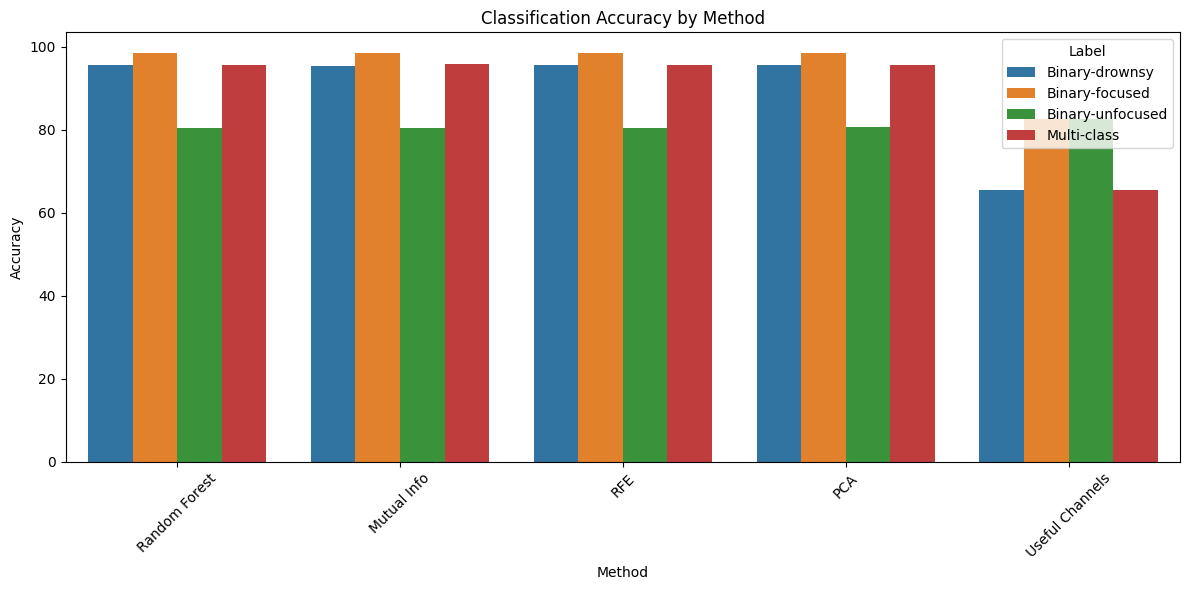

In [25]:
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Method", y="Accuracy", hue="Label")
plt.title("Classification Accuracy by Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()